<a href="https://colab.research.google.com/github/elielodeveloper/NMF-TopicModeling/blob/main/NMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fsspec
import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 4.3 MB/s 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd 
import json
import matplotlib.pyplot as plt

from time import time
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.corpus import stopwords



In [ ]:
with open('/content/drive/MyDrive/baseCovid-19/baseArtigoJanJun2020/baseCovid_1.json') as f:
    Lines = f.readlines()

In [ ]:
n_samples = 100000
n_features = 500
n_components = 20
n_top_words = 20
batch_size = 128
init = "nndsvda"

In [ ]:

def createDocumentDataSet(arrayOfJsons, n_samples):
  seriesList = []
  for idx, line in enumerate(Lines):
    seriesList.append(pd.Series(json.loads(line)))
    if idx == n_samples:
      break
  return pd.DataFrame(seriesList)

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 40), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
df = createDocumentDataSet(Lines, n_samples)
df = df.loc[(df['truncated'] == False) & (df['lang'] == 'pt')]
df.reset_index()
# removing links from dataframe
df = df.replace(to_replace ='(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', value = '', regex = True)
df.head()['text']

,retweet_count,coordinates,in_reply_to_user_id_str,created_at,lang,retweeted,text,in_reply_to_status_id_str,is_quote_status,in_reply_to_screen_name,...,in_reply_to_user_id,id,in_reply_to_status_id,quoted_status_id_str,quoted_status,quoted_status_id,possibly_sensitive,extended_entities,withheld_in_countries,withheld_scope
1,0,None,None,Sat May 30 05:14:11 +0000 2020,pt,False,Ai corona vírus eu te abomino,None,True,None,...,NaN,1266598762656477184,NaN,1265803339608002560,"{'retweet_count': 2961, 'coordinates': None, '...",1.265803e+18,False,NaN,NaN,NaN
3,0,None,None,Tue Apr 14 22:49:24 +0000 2020,pt,False,"a minha mãe acaba de entrar no quarto e diz ""n...",None,False,None,...,NaN,1250194472006291457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,None,None,Sun Mar 22 17:30:15 +0000 2020,pt,False,Man qual a dificuldade de vocês de ficar em ca...,None,False,None,...,NaN,1241779235792072708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,None,70799317,Wed Apr 29 18:26:49 +0000 2020,pt,False,"@UOL Para pessoas iguais ao Sikera jr , é só t...",1255559986639495171,False,UOL,...,7.079932e+07,1255564207698911232,1.255560e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,None,831168536345243648,Mon Apr 20 22:39:57 +0000 2020,pt,False,@_txisr Faz a proposta de novo depois da quare...,1252362091635240967,False,_txisr,...,8.311685e+17,1252366422438604802,1.252362e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.head()['text']

1                       Ai corona vírus eu te abomino 
3    a minha mãe acaba de entrar no quarto e diz "n...
4    Man qual a dificuldade de vocês de ficar em ca...
5    @UOL Para pessoas iguais ao Sikera jr , é só t...
6    @_txisr Faz a proposta de novo depois da quare...
Name: text, dtype: object

In [ ]:
import unicodedata
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')
stopwordsPTBR = map(strip_accents, stopwords.words('portuguese')+["de", "em", "casos", "no", "nao", "que", "cu", "as", "os", "ta", "tos", "se", "ja"])


In [ ]:
print("Extracting tf-idf features for NMF...")
vectorizer_tfidf = TfidfVectorizer( 
    max_df=0.95, min_df=2, max_features=n_features, stop_words=stopwordsPTBR,analyzer='word',
    ngram_range=(1, 1), lowercase=True, use_idf=True, strip_accents='unicode'
)
tfidf_vectorizer = vectorizer_tfidf.fit_transform(df['text'].tolist())
tfidf_vectorizer.shape # (documents, terms)

Extracting tf-idf features for NMF...


(53121, 500)

(42496, 500)

In [ ]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % tfidf_vectorizer.shape
)


#Learn a NMF model for the data X.
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
)

W1 = nmf.fit_transform(tfidf_vectorizer)
H1 = nmf.components_

WmatrixDataFrame = pd.DataFrame(W1)
HmatrixDataFrame = pd.DataFrame(H1)



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=53121 and n_features=500...


In [ ]:
WmatrixDataFrame.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.000000,0.176557,0.000000,0.000000,0.0,0.000000,0.0,0.001270,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.063073,0.003889,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.013569,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003471,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.002797,0.128568,0.0,0.000000,0.0,0.002448,0.001250,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.007103,0.000000
3,0.060521,0.000000,0.000000,0.000000,0.000000,0.0,0.081533,0.0,0.000000,0.000000,0.009232,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.174898
4,0.000000,0.003241,0.000000,0.069128,0.000000,0.0,0.000000,0.0,0.000000,0.008120,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [ ]:
HmatrixDataFrame.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.0,0.0,0.0,0.0,0.0,0.0,3.298823,0.029091,0.005277,0.0,...,0.008083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030209
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.003715,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064673
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


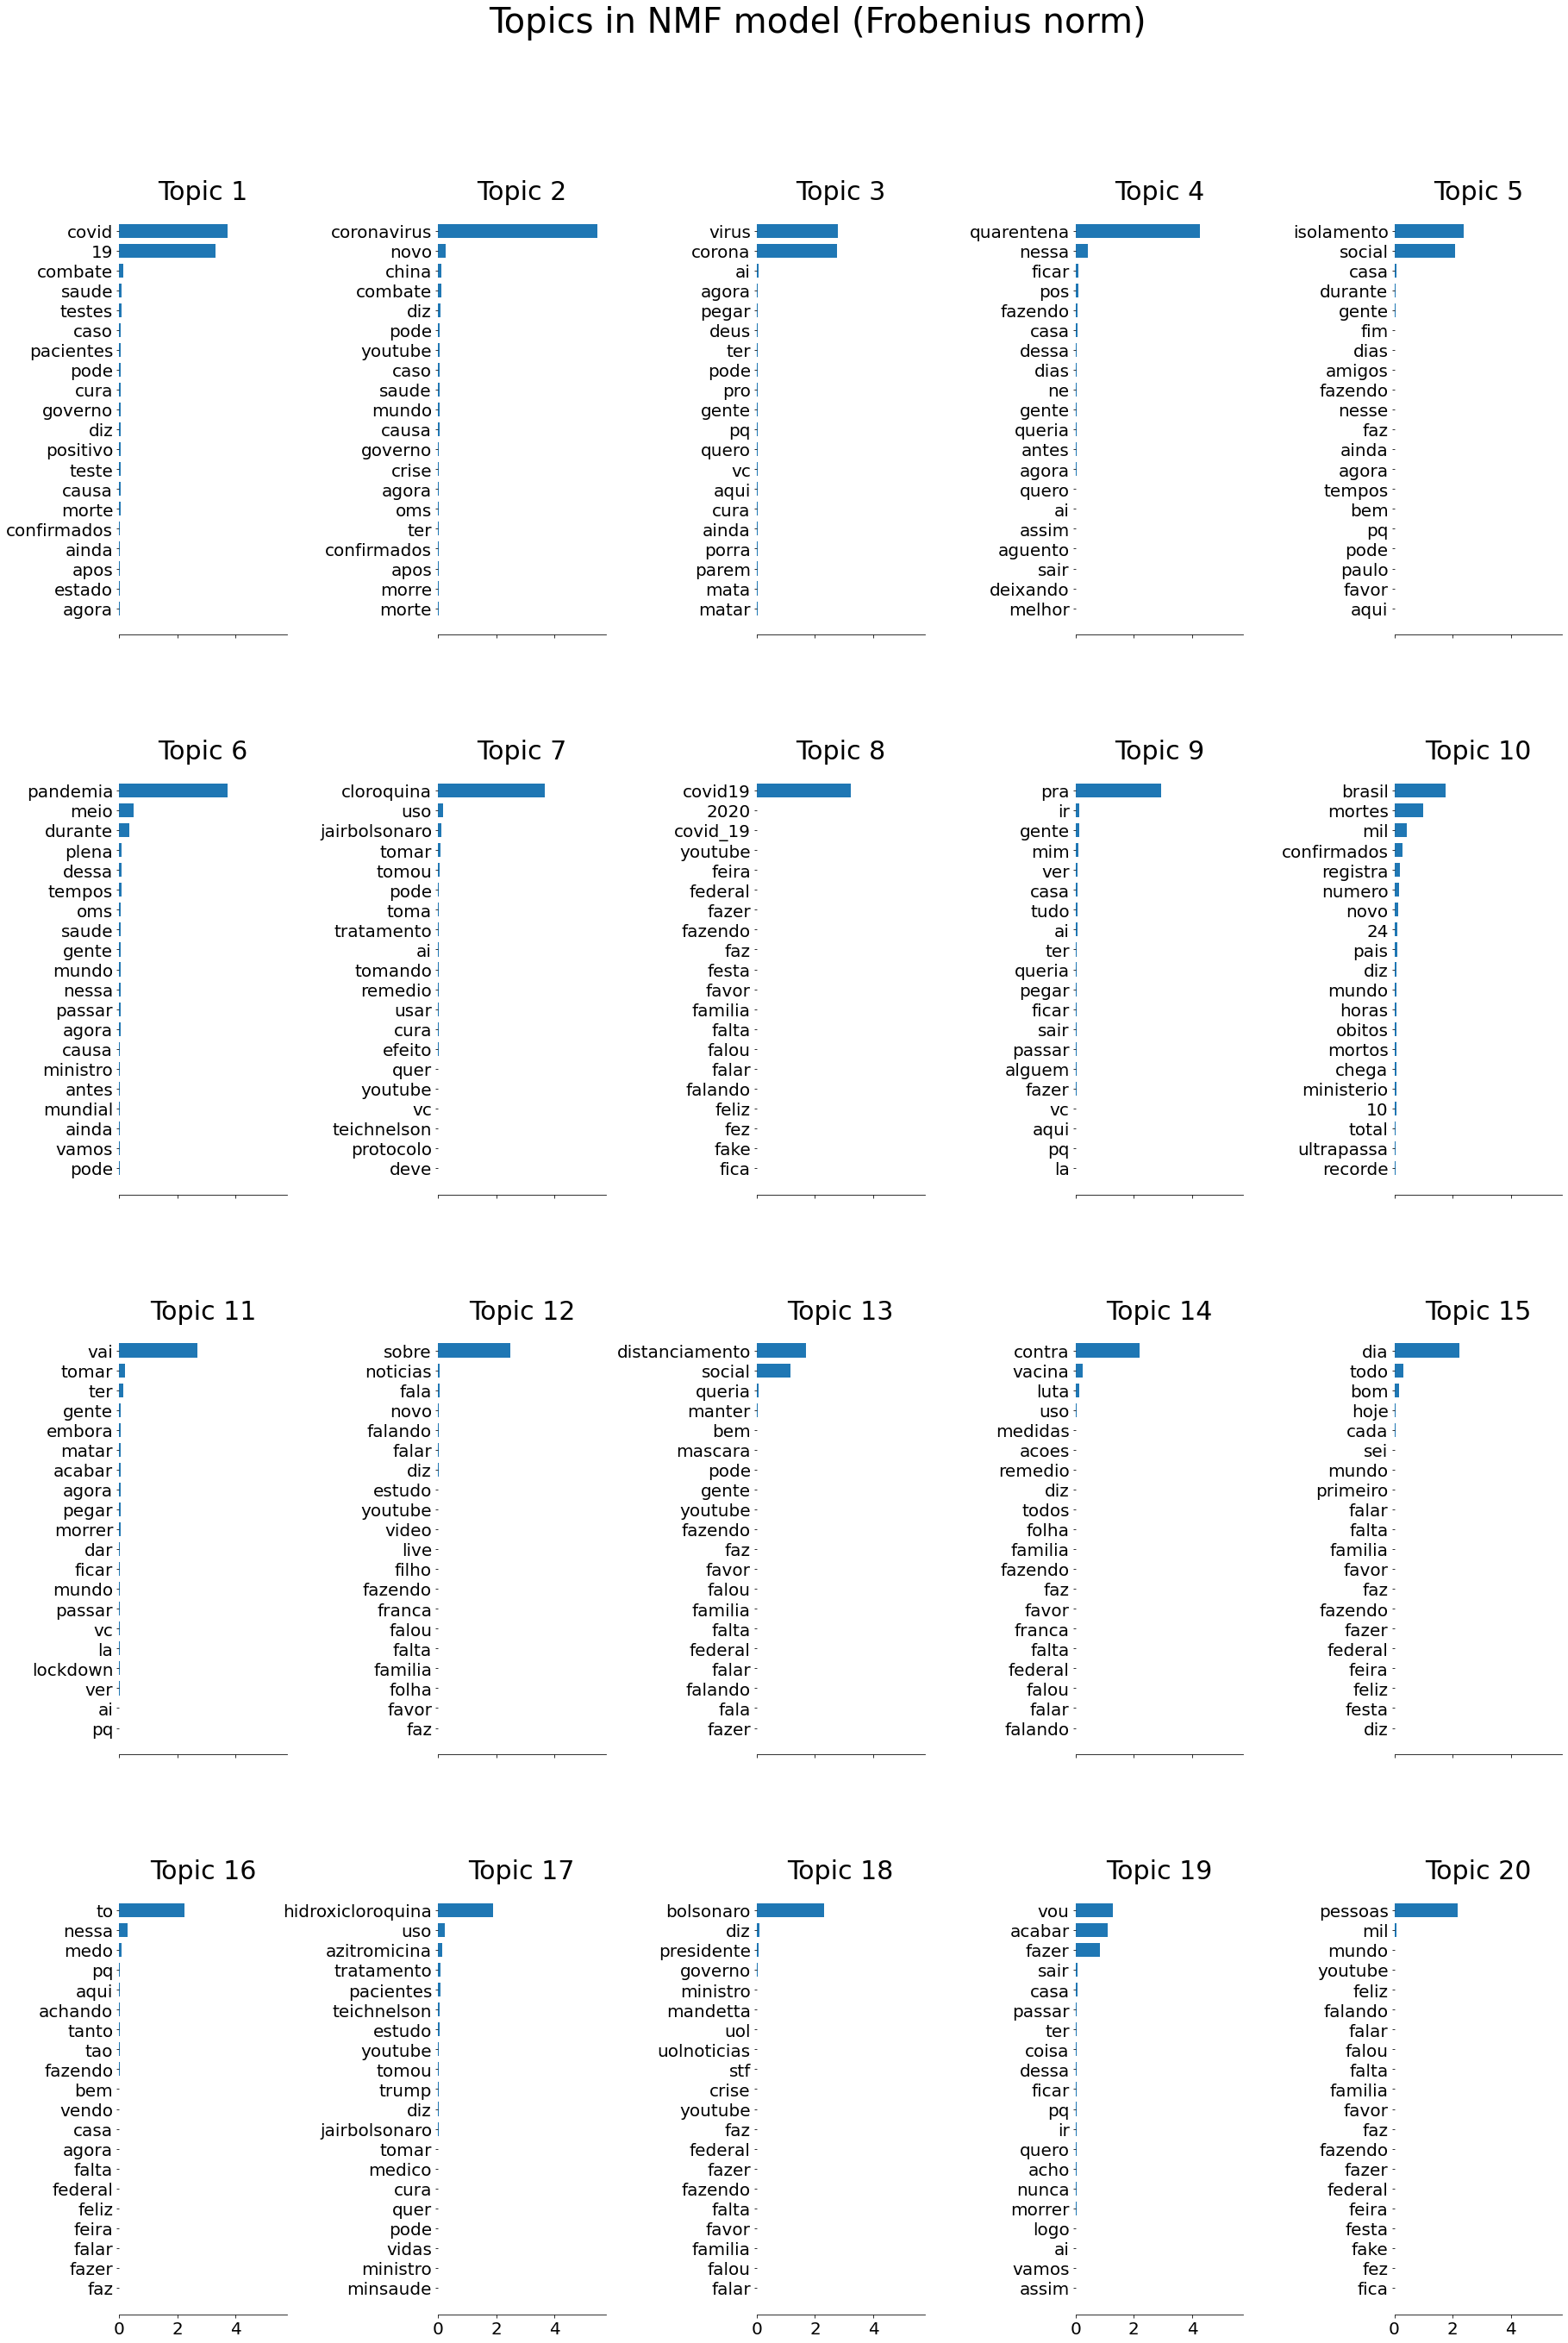

In [ ]:
tf_feature_names = vectorizer_tfidf.get_feature_names()
plot_top_words(nmf, tf_feature_names, n_top_words, 'Topics in NMF model (Frobenius norm)')

In [ ]:
topicList = ["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5","Topic 6", "Topic 7","Topic 8","Topic 9","Topic 10"]
#topicList = ["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5","Topic 6"]
documentosPorTopico = pd.DataFrame(transfomedData, columns=topicList)

In [ ]:
documentosPorTopico.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,0.000000,0.000000,0.110379,0.000000,0.000000,0.000000,0.000942,0.000000,0.000000,0.005506
1,0.040275,0.004509,0.000779,0.000859,0.000993,0.001966,0.001444,0.000000,0.008956,0.001518
2,0.000289,0.000656,0.001309,0.004209,0.071215,0.002289,0.000000,0.000795,0.002506,0.009886
3,0.039524,0.000932,0.001001,0.000490,0.001115,0.000112,0.058651,0.000808,0.001398,0.001107
4,0.000125,0.004079,0.000590,0.046724,0.001921,0.001460,0.002114,0.000000,0.006402,0.000000


In [ ]:
for topic in topicList:
  queryResult = documentosPorTopico.loc[documentosPorTopico[topic] != 0][topic]
  ind_list = list(queryResult.index.values)#Todos os índices daquela consulta
  df.iloc[ind_list]['text'].to_excel('/content/topics/'+topic+'.xlsx')